## **0. Preliminary Settings**

First of all, we need to clone the repository to get access to the code and use utility functions inside the notebook

In [1]:
!git clone https://github.com/mazzio97/DeepComedy.git

project_path = 'DeepComedy/'

Cloning into 'DeepComedy'...
remote: Enumerating objects: 556, done.
remote: Counting objects: 100% (556/556), done.
remote: Compressing objects: 100% (320/320), done.
remote: Total 556 (delta 310), reused 452 (delta 207), pack-reused 0
Receiving objects: 100% (556/556), 1005.45 KiB | 22.34 MiB/s, done.
Resolving deltas: 100% (310/310), done.


This folder is then added to the system path so that the modules can be used inside the notebook

In [2]:
import sys

sys.path.append(project_path + 'src')

Finally, the *Divine Comedy* is loaded and stored in a variable

In [3]:
with open(project_path + 'res/divine_comedy.txt', 'r', encoding='ISO-8859-1') as f:
  divine_comedy = f.read()

print(divine_comedy[:231])
print('\n\n[...]\n\n')
print(divine_comedy[-266:])

INFERNO

- Canto I

Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura,
ché la diritta via era smarrita.

Ahi quanto a dir qual era è cosa dura
esta selva selvaggia e aspra e forte
che nel pensier rinova la paura!


[...]


ma non eran da ciò le proprie penne:
se non che la mia mente fu percossa
da un fulgore in che sua voglia venne.

A l'alta fantasia qui mancò possa;
ma già volgeva il mio disio e 'l velle,
sì come rota ch'igualmente è mossa,

l'amor che move il sole e l'altre stelle.


Also, we set Python's, Numpy's/Keras' and Tensorflow's seeds to guarantee the maximal level of reproducibility

> Though, the results could still differ a little bit due to other randomized routines called during the execution and the inner stochasticity introduced by parallel computing

In [4]:
import random
import numpy as np
import tensorflow as tf

random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

## **1. Data Processing**

### ***1.1 Text Mark***

We use the provided function `mark` to map the original *Divine Comedy* into a marked version containing:

* a marker both at the beginning and at the end of each *cantica*

* a marker both at the beginning and at the end of each *canto*

* a marker between each couple of *tercets*

In [5]:
from text_processing.markers import mark

divine_comedy_marked = mark(divine_comedy)
print(divine_comedy_marked[:260])
print('\n\n[...]\n\n')
print(divine_comedy_marked[-319:])

=startofcantica=
=startofcanto=
Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura,
ché la diritta via era smarrita.
=tercet=
Ahi quanto a dir qual era è cosa dura
esta selva selvaggia e aspra e forte
che nel pensier rinova la paura!
=tercet=


[...]


=tercet=
ma non eran da ciò le proprie penne:
se non che la mia mente fu percossa
da un fulgore in che sua voglia venne.
=tercet=
A l'alta fantasia qui mancò possa;
ma già volgeva il mio disio e 'l velle,
sì come rota ch'igualmente è mossa,
=tercet=
l'amor che move il sole e l'altre stelle.
=endofcanto=
=endofcantica=


### ***1.2 Extracting the Verses***

We want to build a dataset in which the input sequence represents a piece of the *Divine Comedy* going from verse *i* to verse *i+n* and the target sequence represents a piece of the *Divine Comedy* going from verse *i+1* to verse *i+n+1*, thus we need at first to split the dataset and get a list of verses

In [6]:
divine_comedy_split = divine_comedy_marked.split('\n')

for i, verse in enumerate(divine_comedy_split[:20]):
  print(f'{i+1:02} --> {verse}')

01 --> =startofcantica=
02 --> =startofcanto=
03 --> Nel mezzo del cammin di nostra vita
04 --> mi ritrovai per una selva oscura,
05 --> ché la diritta via era smarrita.
06 --> =tercet=
07 --> Ahi quanto a dir qual era è cosa dura
08 --> esta selva selvaggia e aspra e forte
09 --> che nel pensier rinova la paura!
10 --> =tercet=
11 --> Tant' è amara che poco è più morte;
12 --> ma per trattar del ben ch'i' vi trovai,
13 --> dirò de l'altre cose ch'i' v'ho scorte.
14 --> =tercet=
15 --> Io non so ben ridir com' i' v'intrai,
16 --> tant' era pien di sonno a quel punto
17 --> che la verace via abbandonai.
18 --> =tercet=
19 --> Ma poi ch'i' fui al piè d'un colle giunto,
20 --> là dove terminava quella valle


In [7]:
print(len(divine_comedy_split))

19150


### ***1.3 Building the Dataset***

As we know what is the rhyming scheme of the *Divine Comedy*, we know that we will need at least the last *3* verses (*3 actual verses or 2 actual verses + 1 marker verse to indicate the end of the tercet*) to predict a correct fifth one, so we set `seq_length = 3`

> Differently from single-token models, here we have a lower amount of samples and a greater variability (indeed, the dataset is less dense), thus we can choose a `step_length` of *1* and a larger `train_val_split`

In [8]:
seq_length = 3
step_length = 1
batch_size = 64
train_val_split = 0.7

tot_samples = int((len(divine_comedy_split) - seq_length) / step_length)
train_samples = round(tot_samples * train_val_split)

print('Train Samples:', train_samples)
print('  Val Samples:', tot_samples - train_samples)

Train Samples: 13403
  Val Samples: 5744


Now, we map the list of verses into a dataset taking *4* verses per time, and splitting them into an input string of the first *3* verses and a target string of all the verses

In [9]:
from tensorflow.data import Dataset
from tensorflow.strings import reduce_join

def split_input_target(chunk):
  input_text = reduce_join(chunk[:-1], separator='\n') + '\n'
  target_text = reduce_join(chunk, separator='\n') + '\n'
  return input_text, target_text

dataset = Dataset.from_tensor_slices(divine_comedy_split)
dataset = dataset.window(seq_length + 1, step_length, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(seq_length + 1))
dataset = dataset.map(split_input_target).shuffle(tot_samples, seed=0)

Finally, we encode each block of the comedy using the provided `subword_tokenizer` to tokenize the text into subwords, including punctuation

> Some special tokens are reserved to the markers

In [10]:
from text_processing.tokenizers import subword_tokenizer

tokenizer = subword_tokenizer(divine_comedy, target_vocab_size=2048, max_subword_length=3)
print(tokenizer.vocab_size, 'tokens:')
print()
for i, token in enumerate(tokenizer.subwords[:40]):
  print("'{}'".format('\\n' if token == '\n' else token))

3373 tokens:

'=tercet='
'=startofcanto='
'=endofcanto='
'=startofcantica='
'=endofcantica='
'con'
'to'
'dis'
'ta'
'te'
'ti'
'tra'
'chi'
'si'
'ent'
'do'
'and'
'ia'
'par'
'se'
'pre'
'per'
'no'
're'
'acc'
'ne'
'cor'
'pro'
'ver'
'na'
'ar'
'tor'
'vol'
'ndo'
'com'
'cia'
'ven'
'ra'
'ro'
'ett'


In [11]:
def encode_dataset(input_dataset, target_dataset):
  def encode_sample(input, target):
    input = [tokenizer.vocab_size] + tokenizer.encode(input.numpy()) + [tokenizer.vocab_size+1]
    target = [tokenizer.vocab_size] + tokenizer.encode(target.numpy()) + [tokenizer.vocab_size+1]
    return input, target

  input_dataset, target_dataset = tf.py_function(encode_sample, [input_dataset, target_dataset], [tf.int64, tf.int64])
  input_dataset.set_shape([None])
  target_dataset.set_shape([None])
  return input_dataset, target_dataset

train_dataset = dataset.take(train_samples).map(encode_dataset)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.padded_batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = dataset.take(tot_samples - train_samples).map(encode_dataset)
val_dataset = val_dataset.cache()
val_dataset = val_dataset.padded_batch(batch_size)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [12]:
for input, target in train_dataset.take(1):
  input = input.numpy()[0]
  target = target.numpy()[0]

  print(f'Input  Shape: {input.shape}')
  print(f'Target Shape: {target.shape}')
  print()

  print('INPUT:\n')
  print(tokenizer.decode([token for token in input if token < tokenizer.vocab_size]))
  print('\n\n---------------------\n\n')
  print('TARGET:\n')
  print(tokenizer.decode([token for token in target if token < tokenizer.vocab_size]))

Input  Shape: (71,)
Target Shape: (79,)

INPUT:

così mi parve da luce rifratta
quivi dinanzi a me esser percosso;
per che a fuggir la mia vista fu ratta.



---------------------


TARGET:

così mi parve da luce rifratta
quivi dinanzi a me esser percosso;
per che a fuggir la mia vista fu ratta.
=tercet=



## **2. Model**

### ***2.1 Architecture***

The ***Transformer*** is a state-of-the-art model for *Natural Language Processing* and *Machine Translation* tasks proposed by *Vaswani et al.* in 2017 (https://arxiv.org/pdf/1706.03762v5.pdf)

* It consists of an *Encoder* and a *Decoder*, each of them made up of a given number of layers having two sub-modules: a *Multi-Head Attention* (with a parametric number of heads) sub-module and a classical *Feed-Foward* sub-module

* Also, as it does not use recurrent layers to process strictly sequential data, it both process the input data with a standard token encoding and a *positional encoding* as well

> The variable parameters of the model are:
> * the number of layers for the *Encoder* and the *Decoder*
> * the number of heads for the *Multi-Head Attention* sub-module
> * the dimension of all sub-layers in the model, as well as the embedding layers, known as *d_model*
> * the inner feed-forward dimension, known as *dff*
> * the dropout rate

In [13]:
from transformer.functions import *
from transformer.model import *

history = {'train loss': [], 'train acc': [], 'val loss': [], 'val acc': []}

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  with tf.GradientTape() as tape:
    predictions, _ = model(inp, tar_inp, True, enc_padding_mask, combined_mask, dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, model.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

@tf.function(input_signature=step_signature)
def val_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  with tf.GradientTape() as tape:
    predictions, _ = model(inp, tar_inp, True, enc_padding_mask, combined_mask, dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  val_loss(loss)
  val_accuracy(tar_real, predictions)

In [14]:
from tensorflow.keras.optimizers import Adam

num_layers = 3
num_heads = 4
d_model = 256
dff = 512
dropout = 0.2
input_vocab_size = tokenizer.vocab_size + 2
target_vocab_size = tokenizer.vocab_size + 2
optimizer = Adam(CustomSchedule(d_model), beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model = Transformer(
    num_layers, d_model, num_heads, dff,
    input_vocab_size, target_vocab_size,
    pe_input=input_vocab_size, pe_target=target_vocab_size,
    rate=dropout
)

for (inp, tar) in train_dataset.take(1):
  val_step(inp, tar)

model.summary()

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  2445312   
_________________________________________________________________
decoder (Decoder)            multiple                  3236352   
_________________________________________________________________
dense_48 (Dense)             multiple                  867375    
Total params: 6,549,039
Trainable params: 6,549,039
Non-trainable params: 0
_________________________________________________________________


### ***2.2 Training***

In [15]:
import os
import time

epochs = 0

if os.path.isfile(project_path + 'model.h5'):
  model.load_weights(project_path + 'model.h5')
  print('Model restored')
else:
  epochs = 70
  batches_interval = 20

  for epoch in range(epochs):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()
    print(f'Starting Epoch {epoch+1}/{epochs}')
    
    for (batch, (inp, tar)) in enumerate(train_dataset):
      train_step(inp, tar)
      if (batch + 1) % batches_interval == 0:
        print(f'  > Batch {batch+1}', end=' \t\t ')
        print(f'- train_loss: {train_loss.result():.4f} - train_acc: {train_accuracy.result():.4f}')      
    history['train loss'].append(train_loss.result())
    history['train acc'].append(train_accuracy.result())

    for (batch, (inp, tar)) in enumerate(val_dataset):
      val_step(inp, tar)  
    history['val loss'].append(val_loss.result())
    history['val acc'].append(val_accuracy.result())

    elapsed = time.time() - start
    print(f'Ending Epoch {epoch+1}/{epochs}', end=' \t ')
    print(f'- train_loss: {history["train loss"][-1]:.4f} - train_acc: {history["train acc"][-1]:.4f}', end=' ')
    print(f'- val_loss: {history["val loss"][-1]:.4f} - val_acc: {history["val acc"][-1]:.4f}')
    print(f'Elapsed Time {elapsed:.2f}s\n')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Model restored


Here's a graphical representation of the improvement of the model, with respect both to the loss and the accuracy, across the epochs

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
sns.set_context('notebook')

if epochs > 0:
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(np.arange(epochs) + 1, history['train loss'], label='train')
  plt.plot(np.arange(epochs) + 1, history['val loss'], label='val')
  plt.legend()
  plt.title('Loss')

  plt.subplot(1, 2, 2)
  plt.plot(np.arange(epochs) + 1, history['train acc'], label='train')
  plt.plot(np.arange(epochs) + 1, history['val acc'], label='val')
  plt.legend()
  plt.title('Accuracy')

  plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **3. Results**

Here, at first, we will use the model to predict some verses and show the respective attention plots to understand how the model is behaving, then, we will proceed with the generation of a full canto, which uses a `temperature_factor` to allow some degree of randomness

> The next token is chosen among a subset of those having a probability which is at least `1 / temperature_factor` with respect to the maximal one

> It goes without saying that a higher `temperature_factor` leads to a more explorative generation, while a lower `temperature_factor` leads to a more conservative one (in particular, with `temperature_factor = 1` the generation is completely deterministic)

### ***3.1 Evaluation***



In [17]:
from tensorflow.nn import softmax
from text_processing.markers import unmark, MARKERS

newline_token = tokenizer.encode('\n')[0]

def evaluate(inp_list, max_length=35, temperature_factor=1, verbose=False):
  # the input is the tokenized string obtained from the given input list
  input = tokenizer.encode('\n'.join(inp_list))

  # the encoder input is surrounded by a start and an end token
  encoder_input = tf.expand_dims([tokenizer.vocab_size] + input + [tokenizer.vocab_size + 1], 0)

  # the decoder input is the same sentence preceded by a start token
  decoder_input = tf.expand_dims([tokenizer.vocab_size] + input, 0)

  # the final output of the evaluation (initially, this is an empty list)
  output = []

  # we repeat the process to get the entire verse (until the end token or the newline token is predicted)
  for i in range(max_length):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, decoder_input)  
    logits, attention_weights = model(
        encoder_input, decoder_input, False,
        enc_padding_mask, combined_mask, dec_padding_mask
    )

    # we get the probabilities for the decoded token (the last one)
    probabilities = softmax(logits[0, -1, :tokenizer.vocab_size]).numpy()

    # we take a subset of possible tokens whose probability is at least 1/temperature_factor of the maximal one
    indices = np.arange(tokenizer.vocab_size)[probabilities >= probabilities.max() / temperature_factor]

    # we renormalize this subset using, again, a softmax activation
    probabilities = softmax(probabilities[probabilities >= probabilities.max() / temperature_factor]).numpy()
    
    # the id is randomly chosen among the indices according to the computed probabilities
    predicted_id = np.random.choice(indices, size=1, p=probabilities)[0]
    
    # if the token coincides with the nd token or the newline token, the generation is interrupted
    if predicted_id == newline_token or predicted_id >= tokenizer.vocab_size:
      break

    # otherwise the token is appended both to the new decoder input and to the final output
    decoder_input = tf.concat([decoder_input, [[predicted_id]]], axis=-1)
    output.append(predicted_id)

    if verbose:
      print(tokenizer.decode([predicted_id]), end='')

  return output, attention_weights

In [18]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(25, 25))  
  sentence = tokenizer.encode(sentence)
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(attention.shape[0], 1, head+1)
    ax.matshow(attention[head][:-1, :], cmap='gray')
    fontdict = {'fontsize': 18}    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))    
    ax.set_ylim(len(result)-1.5, -0.5)
    ax.set_xticklabels(['<start>'] + [tokenizer.decode([i]) for i in sentence] + ['<end>'], fontdict=fontdict, rotation=90)
    ax.set_yticklabels([tokenizer.decode([i]) for i in result if 0 < i < tokenizer.vocab_size], fontdict=fontdict)
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

INPUT:
=tercet=
Tant' è amara che poco è più morte;
ma per trattar del ben ch'i' vi trovai,


TARGET:
dirò de l'altre cose che tu mi porte.



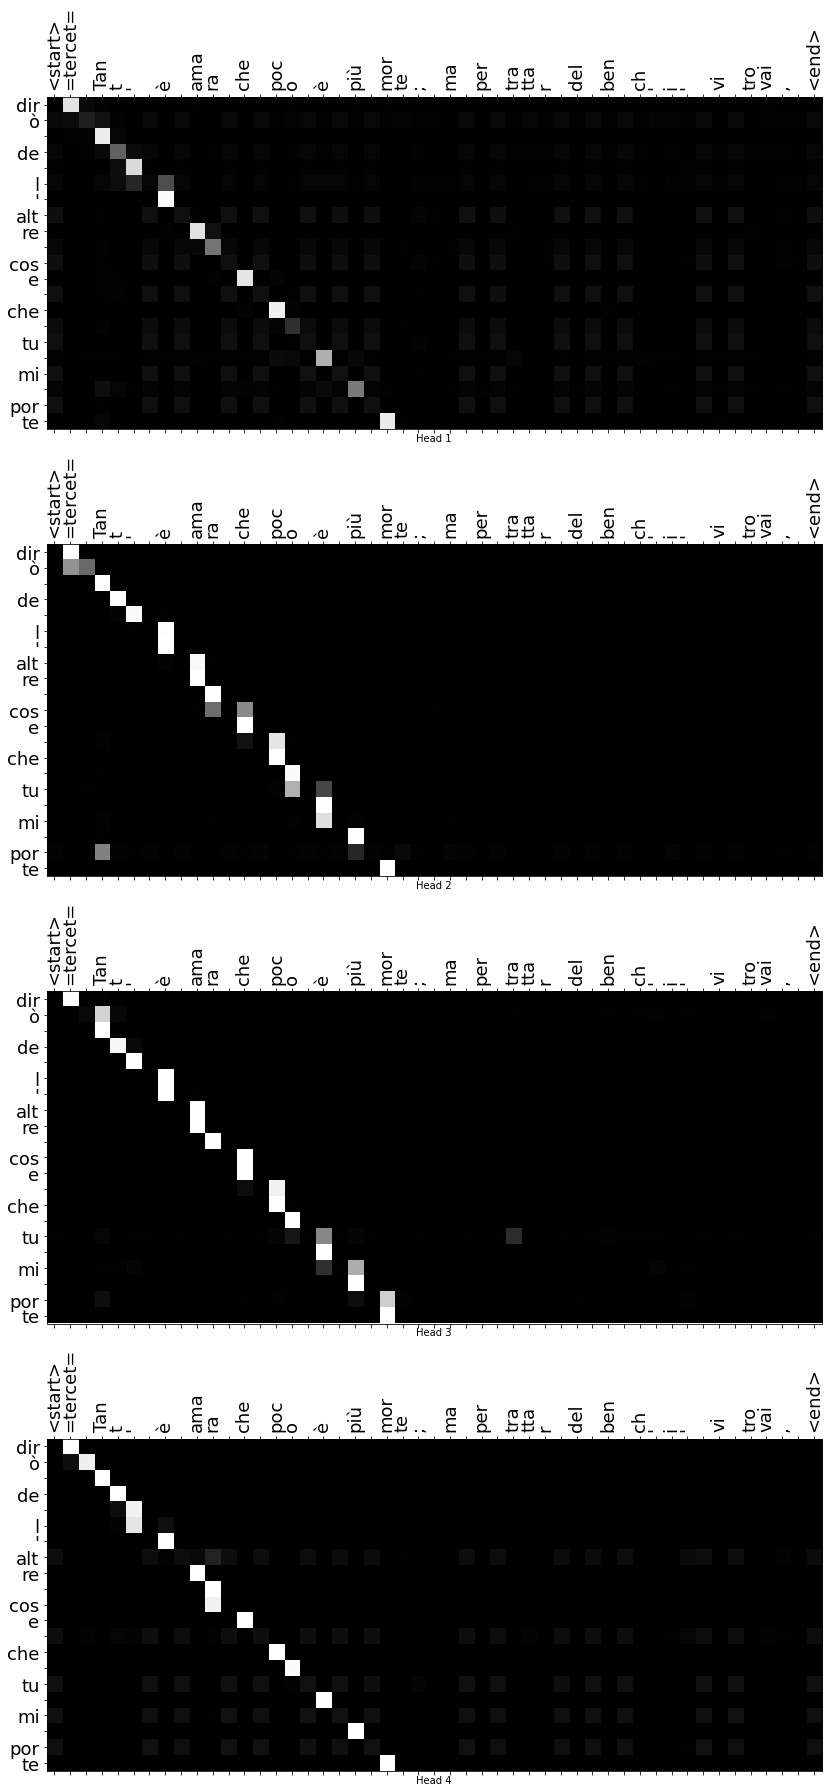

In [19]:
i = 9
sentence_list = divine_comedy_split[i:i+seq_length] + ['']

sentence = '\n'.join(sentence_list)
target, attention_weights = evaluate(sentence_list)

print('INPUT:')
print(sentence)
print()
print('TARGET:')
print(tokenizer.decode([t for t in target if 0 < t < tokenizer.vocab_size]))
print()
plot_attention_weights(attention_weights, sentence, target, 'decoder_layer3_block2')

### ***3.2 Generation***

In [20]:
def generate(
    input_string=divine_comedy_marked[:386], # first three tercets of the comedy
    max_iterations=250, end_marker=MARKERS['canto end'],
    temperature_factor=1.0, verbose=False
):
  # at the beginning, the generated string is the encoding of the input string (plus a newline character)
  generated_string = input_string

  for i in range(max_iterations):
    # the input list is made up of the last 'seq_length' verses (-1 for the last blank verse to be filled)
    input_list = generated_string.split('\n')[-seq_length-1:]

    # the generated verse is then decoded
    target, _ = evaluate(input_list, temperature_factor=temperature_factor, verbose=verbose)
    generated_verse = tokenizer.decode(target)
    if verbose:
      print()

    # if the verse coincides with the end marker, the generation is interrupted, otherwise it is appended with a newline
    if generated_verse == end_marker:
      break
    generated_string += generated_verse + '\n'
  
  # we finally return the decoded (and unmarked) string, excluding the input provided by the user
  return unmark(generated_string[len(input_string):])

In [21]:
generated_canto = generate(temperature_factor=1.0, verbose=True)

O dolce padre mio, figliuol, che fai
tanto maravigliar, se tu vuo' ch'i' credi;
ma sol che 'l tua maggior mai fai mai".
=tercet=
"O superba che, tu che i miei piedi
non vedi omai; ma vedi quivi
si volse con li occhi mi 

KeyboardInterrupt: ignored

In [ ]:
from metrics.metrics import evaluate

evaluate(generated_canto, divine_comedy)

In [ ]:
print(generated_canto)